In [1]:
import numpy as np
import scipy as sc
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd
import IPython.display as ipd
import os

In [2]:
files = os.listdir('data/MS-SNSD/clean_test/')
rand1 = np.random.randint(len(files))
rand2 = np.random.randint(len(files))

if (rand2 == rand1):
    rand2 = np.random.randint(len(files))


audio_file = 'data/MS-SNSD/clean_test/' + files[rand1]
interferer_file = 'data/MS-SNSD/clean_test/' + files[rand2]

In [3]:
Fs, audio_dat = wavfile.read(audio_file)
audio_dat = audio_dat/np.max(np.abs(audio_dat))

interferer = 1
Fs = 16e3
time = np.linspace(0, len(audio_dat)/Fs, len(audio_dat))

if interferer:
    _, interfere_dat = wavfile.read(interferer_file)
    interfere_dat = interfere_dat/np.max(np.abs(interfere_dat))
else:
    interferer = np.zeros(shape = time.shape)
    
ipd.Audio(interfere_dat, rate = Fs)

In [4]:
clean_speech_var = np.linalg.norm(audio_dat - np.mean(audio_dat))**2
ipd.Audio(audio_dat, rate = Fs)

Text(0, 0.5, 'Bits')

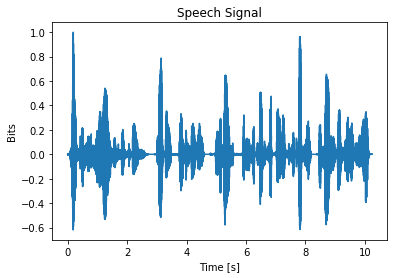

In [5]:
plt.figure(1)
plt.plot(time, audio_dat)
plt.title('Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Bits')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


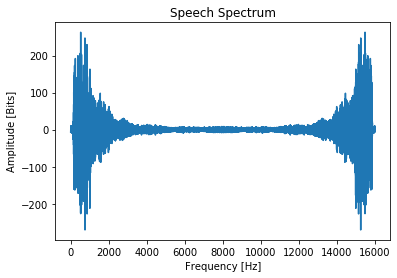

In [6]:
fft_speech = sc.fft(audio_dat)
F = np.linspace(0, Fs, len(audio_dat))

plt.figure(2)
plt.plot(F, fft_speech)
plt.title('Speech Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [Bits]')

# Propagating each frequency component to the specific location
sensor_sig = np.zeros([1, len(F)], dtype = np.complex64)
noise = np.zeros([1, len(F)], dtype = np.float64)
snr = -20
sir = -20

c = 343 # Speed of sound
kappa_vec = 2*np.pi*F/c # Kappa Vec
sensor_var = np.linalg.norm(audio_dat - np.mean(audio_dat))**2
sensor_rms_amp = np.sqrt(np.mean(np.abs(audio_dat)**2))
noise_amp = sensor_rms_amp/(10**(snr/20))
interferer_amp = sensor_rms_amp/(10**(sir/20))

interfere = np.zeros(time.shape, dtype = np.complex64)

if interferer:
    noise_rms = np.sqrt(np.mean(np.abs(audio_dat)**2))
    if(len(interfere_dat)>=len(time)):
        interfere = 1.414*interferer_amp/noise_rms*interfere_dat[0:len(time)]
    else:
        interfere[0:len(interfere_dat)] = 1.414*interferer_amp/noise_rms*interfere_dat
    white_noise = noise_amp*np.random.normal(0, 1, len(time))
    noise = interfere + white_noise
else:
    noise = noise_amp*np.random.normal(0, 1, len(time))
    
sensor_sig = audio_dat + noise

sensor_interferer_var = np.linalg.norm(interfere - np.mean(interfere))**2
sensor_noise_interferer_var = np.linalg.norm(noise - np.mean(noise))**2
sensor_noise_var = np.linalg.norm(white_noise - np.mean(white_noise))**2

In [7]:
computed_SIR = 10*np.log10(sensor_var/sensor_interferer_var)
computed_SNR = 10*np.log10(sensor_var/sensor_noise_var)
computed_SINR = 10*np.log10(sensor_var/sensor_noise_interferer_var)

print(computed_SIR, computed_SNR, computed_SINR)
print(noise_amp)
print(sensor_rms_amp)

-25.22740253104155 -20.003505393260358 -26.388567615693788
0.7554321549796698
0.07554321549796698


## Collected signal

In [8]:
ipd.Audio(np.real(sensor_sig), rate = Fs, normalize=True)

## LMS Algorithm for ANC filter weights

In [9]:
M = 16
mu = 1e-6
w = np.zeros(shape = (M))
y = np.zeros(shape = time.shape)
e = y

for m in range(M, len(time)):
    s_sum = 0
    for i in range(0, M):
        s_sum = s_sum + w[i]*sensor_sig[m - i]
    
    y[m] = s_sum
    e[m] = audio_dat[m] - y[m]
    
    for i in range(0, M):
        w[i] = w[i] + 2*mu*e[m]*sensor_sig[m - i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


## Clean Signal

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


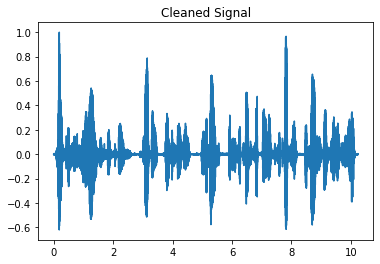

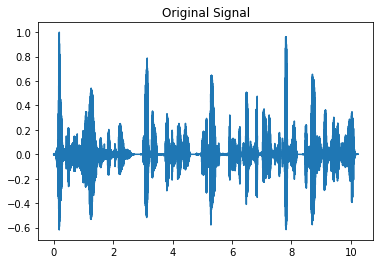

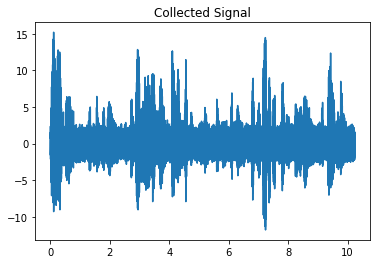

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


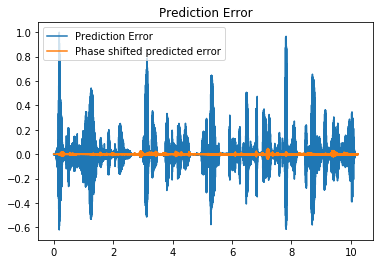

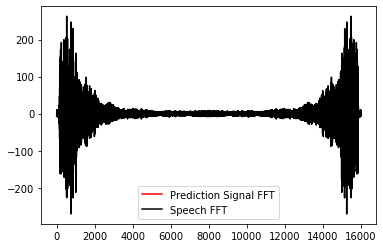

In [10]:
y_fft = sc.ifft(y)
plt.figure(101)
plt.plot(time, y)
plt.title('Cleaned Signal')

plt.figure(102)
plt.plot(time, audio_dat)
plt.title('Original Signal')

plt.figure(1021)
plt.plot(time, sensor_sig)
plt.title('Collected Signal')

plt.figure(103)
plt.plot(time, e)
plt.plot(time, audio_dat - y*np.exp(-1j*M/len(time)*np.pi))
plt.legend(['Prediction Error', 'Phase shifted predicted error'])
plt.title('Prediction Error')


plt.figure(104)
plt.plot(F, np.real(y_fft), 'r')
plt.plot(F, np.real(fft_speech), 'k')
plt.legend(['Prediction Signal FFT', 'Speech FFT'])

## Plot Filter Weights

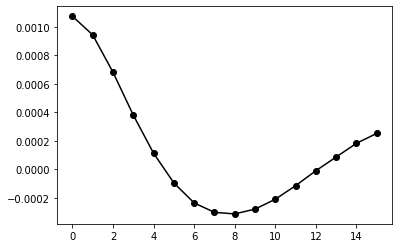

In [11]:
plt.figure(1)
plt.plot(w, 'ko-')

#plt.figure(2, figsize=(12, 8), dpi=80)
#for k in range(0, M):
#    plt.subplot(4, 4, k + 1)
#    plt.plot(time, w[:, k])


## Clean signal playback

In [12]:
ipd.Audio(np.real(y), rate = Fs, normalize=True)

In [13]:
ipd.Audio(np.real(sensor_sig - y), rate = Fs, normalize=True)

## Calculation of Clean SNR

In [14]:
clean_sig_var = np.linalg.norm(y - np.mean(y))**2
rem_sig_var = np.linalg.norm((sensor_sig - y) - np.mean(sensor_sig - y))**2
clean_snr = clean_sig_var/rem_sig_var
print('Clean Sig SNR: ' + str(clean_snr))

Clean Sig SNR: 0.002282652917041938
